In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import tensorflow_addons as tfa

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
SR_data = np.load('/content/drive/MyDrive/ECG_LEAD_arrarys/SR_lead8_f.npy')

In [6]:
AFIB_data=np.load('/content/drive/MyDrive/ECG_LEAD_arrarys/AFIB_lead8_f.npy')

In [7]:
SR_data.shape

(1000, 217, 334, 3)

In [8]:
input_shape=SR_data[0].shape

In [9]:
input_shape

(217, 334, 3)

In [10]:
class_SR=np.zeros((1000,1))
class_AFIB=np.ones((1000,1))
Y_data=np.append(class_SR,class_AFIB)
Y_data.shape

(2000,)

In [11]:
data=np.concatenate((SR_data,AFIB_data))

In [12]:
data.shape

(2000, 217, 334, 3)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(data,Y_data,test_size=0.2,shuffle=True,random_state=42)


In [14]:
Y_train=Y_train.reshape(1600,1)
Y_test=Y_test.reshape(400,1)

In [15]:
Y_train.shape

(1600, 1)

In [16]:
SR_data = np.load('/content/drive/MyDrive/ECG_LEAD_arrarys/SR_lead8_f.npy')
AFIB_data=np.load('/content/drive/MyDrive/ECG_LEAD_arrarys/AFIB_lead8_f.npy')
SR_data.shape
input_shape=SR_data[0].shape
class_SR=np.zeros((1000,1))
class_AFIB=np.ones((1000,1))
Y_data=np.append(class_SR,class_AFIB)
data=np.concatenate((SR_data,AFIB_data))
X_train8, X_test8, Y_train8, Y_test8 = train_test_split(data,Y_data,test_size=0.2,shuffle=True,random_state=42)
#Y_train8=Y_train8.reshape(1600,1)
#Y_test8=Y_test8.reshape(400,1)

In [17]:
SR_data = np.load('/content/drive/MyDrive/SR_100_samp.npy')
AFIB_data=np.load('/content/drive/MyDrive/AFIB_100_samp.npy')
SR_data.shape
input_shape=SR_data[0].shape
class_SR=np.zeros((1000,1))
class_AFIB=np.ones((1000,1))
Y_data=np.append(class_SR,class_AFIB)
data=np.concatenate((SR_data,AFIB_data))
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(data,Y_data,test_size=0.2,shuffle=True,random_state=42)
Y_train2=Y_train2.reshape(1600,1)
Y_test2=Y_test2.reshape(400,1)

In [18]:
num_classes = 2


In [19]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
image_size = 100  # We'll resize input images to this size
patch_size = 10  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(X_train)

In [21]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [22]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [23]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Image size: 100 X 100
Patch size: 10 X 10
Patches per image: 100
Elements per patch: 300


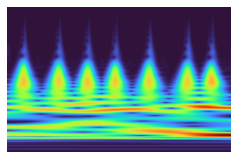

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = X_train[np.random.choice(range(X_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")


In [25]:
 def transformer_encoder(input_patches):
        layer1 = layers.LayerNormalization(epsilon=1e-6)(input_patches) #normalization
        attention_output = layers.MultiHeadAttention(  
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(layer1, layer1)   #multiheaded attention
        layer2 = layers.Add()([attention_output, input_patches]) #adding attention output with encoded patches
        layer3 = layers.LayerNormalization(epsilon=1e-6)(layer2)  #normalization
        layer3 = mlp(layer3, hidden_units=transformer_units, dropout_rate=0.1) #Multilayer perceptron
        input_patches = layers.Add()([layer3, layer2])    #adding MLP output with normalized encoded patches output
        return input_patches


In [26]:
 def leadattention(inputs):
      augmented = data_augmentation(inputs) #data augmentation
      patches = Patches(patch_size)(augmented) #splitting image into patches
      encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
      for _ in range(transformer_layers):
        encoded_patches=transformer_encoder(encoded_patches)   
      representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)  #aggregating data from all transformer blocks and layers
      representation = layers.Flatten()(representation)     #flatten the data for MLP
      return representation 


In [27]:
def create_ECG_image_classifier():
    input1 = layers.Input(shape=input_shape)
    input2 = layers.Input(shape=input_shape)
    rep1=leadattention(input1)
    rep2=leadattention(input2)
    representationm=layers.concatenate([rep1,rep2])
    representation = layers.Dropout(0.5)(representationm)
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes)(features)  #final binary classification 
    model = keras.Model(inputs=[input1,input2], outputs=logits)
    return model

In [28]:
y_train = keras.utils.to_categorical(Y_train,2)
y_test = keras.utils.to_categorical(Y_test8,2)

In [29]:

def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    model.summary()

    history = model.fit(
        x=[X_train8,X_train2],
        y=Y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate([X_test8,X_test2],Y_test8)
    y_pred1 = model.predict([X_test8,X_test2])
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history,y_pred1


ECG_image_classifier = create_ECG_image_classifier()
history,y_pred1 = run_experiment(ECG_image_classifier)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 217, 334, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 217, 334, 3  0           []                               
                                )]                                                                
                                                                                                  
 data_augmentation (Sequential)  (None, 100, 100, 3)  7          ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [30]:
y_pred1.shape

(400, 2)

In [31]:
y_final=np.zeros(400);

In [32]:
y_final.shape

(400,)

In [33]:
for i in range(0,400):
  if (y_pred1[i,0]>y_pred1[i,1]):
      y_final[i]=0;
  else:
    y_final[i]=1;

    


In [34]:
Y_test8.shape

(400,)

In [35]:
y_final.shape

(400,)

In [36]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [37]:
precision = precision_score(Y_test8,y_final)
recall = recall_score(Y_test8,y_final)

In [38]:
print('Precision: ',precision)
print('Recall: ',recall)

Precision:  0.933649289099526
Recall:  0.9800995024875622


In [39]:
from sklearn.metrics import confusion_matrix


In [40]:
F1 = 2 * (precision * recall) / (precision + recall)


In [41]:
print(F1)

0.9563106796116504


dict_keys(['loss', 'accuracy', 'top-5-accuracy', 'val_loss', 'val_accuracy', 'val_top-5-accuracy'])


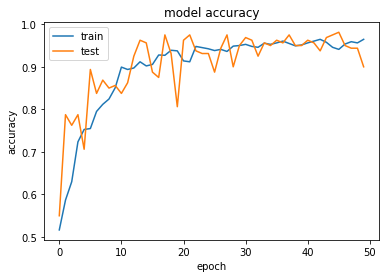

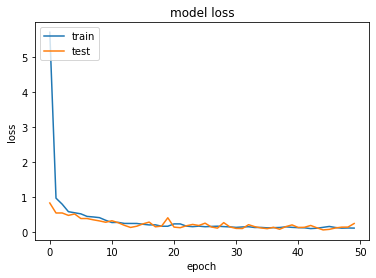

In [42]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()